# Machine Learning

## Lab02 - Enhanced: Let's PyTorch, Light the Flame of Learning Machine Learning

### Overview

**Original Lab Objectives:**
1. Provide a hands-on exposure to PyTorch, a high-level neural network library.
2. Introduce the basics of building, training, and testing models in PyTorch using the FashionMNIST dataset.
3. Emphasize exploration and experimentation without a detailed understanding of "why" it works yet.

## Enhanced Lab Objectives:

1. Enhanced Documentation: Detailed comments and docstrings to explain the code and concepts.
2. Advanced Features: Custom model implementation, GPU support, and checkpointing.
3. Validation Loop: A validation set to monitor overfitting.
4. Comparative Analysis: Training and comparing two models.
5. Visualizations: Training curves, confusion matrix, and misclassified images.

## Installing Dependencies


In [15]:
%pip install torchvision --no-cache-dir --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [16]:
import torch
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from timeit import default_timer as timer
import os
import itertools
from sklearn.metrics import confusion_matrix

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Check for GPU and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Data Loading and Transformation

We load the FashionMNIST dataset and apply the following transformations:

- **ToTensor:** Converts images to PyTorch tensors.
- **Normalize:** Scales the pixel values to have a mean of 0.5 and a standard deviation of 0.5.

In [17]:
# Data transformation: convert images to tensor and normalize
mean, std = (0.5,), (0.5,)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the FashionMNIST dataset (download if not already present)
dataset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)

# Split the dataset into training and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

print(f'Training dataset size: {len(train_data)}')
print(f'Validation dataset size: {len(val_data)}')

Processing...
Done!
Training dataset size: 54000
Validation dataset size: 6000


/Users/haziqzairul/.local/share/virtualenvs/datamining-5l9yRiuj/lib/python3.12/site-packages/torchvision/datasets/mnist.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

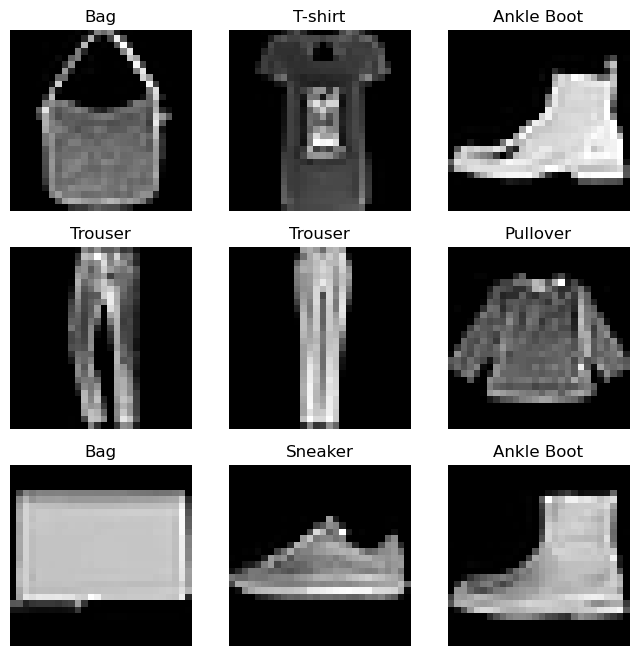

In [12]:
# Function to display sample images with labels
def show_sample_images(data, labels_map, num_samples=9):
    """
    Display a grid of sample images from the dataset.
    
    Args:
        data (Dataset): The dataset to sample images from.
        labels_map (list): A list mapping label indices to human-readable class names.
        num_samples (int): Number of sample images to display.
    """
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis('off')
        plt.imshow(img.squeeze(), cmap='gray')
    plt.show()

# Mapping from numerical labels to class names for FashionMNIST
FMNIST_labels_map = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                     'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Display sample images from the training data
show_sample_images(train_data, FMNIST_labels_map)

## Creating DataLoaders

We create DataLoaders for the training and validation sets to efficiently feed data to our models.

In [13]:
# Create DataLoaders for training and validation data
batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Explore one batch of data
images, labels = next(iter(train_dataloader))
print('Batch size:', len(images))
print('Image shape:', images[0].shape)

Batch size: 64
Image shape: torch.Size([1, 28, 28])


## Model Definitions

We define two models:

1. **Sequential Model:** Built using `nn.Sequential`.
2. **Custom Model:** Defined by subclassing `nn.Module` for greater flexibility.

In [14]:
# Define a model using nn.Sequential
def create_sequential_model():
    """
    Create a simple feedforward neural network using nn.Sequential.
    """
    return nn.Sequential(
        nn.Flatten(),            # Flatten the image
        nn.Linear(784, 128),     # First hidden layer
        nn.ReLU(),               # Activation function
        nn.Linear(128, 64),      # Second hidden layer
        nn.ReLU(),               # Activation function
        nn.Linear(64, 10),       # Output layer for 10 classes
        nn.LogSoftmax(dim=1)     # LogSoftmax for probabilistic output
    )

# Define a custom model by subclassing nn.Module
class CustomModel(nn.Module):
    """
    A custom neural network model.
    """
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Instantiate models and move them to the chosen device
sequential_model = create_sequential_model().to(device)
custom_model = CustomModel().to(device)

## Training and Validation Functions with Checkpointing

We define functions to train for one epoch, validate the model, and perform full training with checkpointing (saving the model if validation accuracy improves).

In [15]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            total_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(val_loader.dataset)
    return total_loss / len(val_loader), accuracy

def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, model_name='model'):
    """
    Train the model and validate it after each epoch.
    """
    loss_history = []
    val_accuracy_history = []

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        loss_history.append(train_loss)
        val_accuracy_history.append(val_accuracy)
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')

    return loss_history, val_accuracy_history


## Training and Comparing Models

We now set up the optimizer and loss function, then train both models (Sequential and Custom) to compare their performance.

In [16]:
# Set up optimizer and loss function for the sequential model
optimizer_seq = optim.SGD(sequential_model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Train the sequential model
print('Training Sequential Model')
loss_history_seq, val_accuracy_history_seq = train_model(sequential_model, train_dataloader, val_dataloader, optimizer_seq, criterion, device, num_epochs=5, model_name='sequential_model')

# Set up optimizer for the custom model
optimizer_custom = optim.SGD(custom_model.parameters(), lr=0.01)

# Train the custom model
print('\nTraining Custom Model')
loss_history_custom, val_accuracy_history_custom = train_model(custom_model, train_dataloader, val_dataloader, optimizer_custom, criterion, device, num_epochs=5, model_name='custom_model')

Training Sequential Model
Epoch 1/5
Train Loss: 1.0642 | Val Loss: 0.6265 | Val Accuracy: 0.7642
Epoch 2/5
Train Loss: 0.5680 | Val Loss: 0.5067 | Val Accuracy: 0.8162
Epoch 3/5
Train Loss: 0.4974 | Val Loss: 0.4753 | Val Accuracy: 0.8233
Epoch 4/5
Train Loss: 0.4630 | Val Loss: 0.4484 | Val Accuracy: 0.8353
Epoch 5/5
Train Loss: 0.4405 | Val Loss: 0.4221 | Val Accuracy: 0.8468

Training Custom Model
Epoch 1/5
Train Loss: 1.0460 | Val Loss: 0.6411 | Val Accuracy: 0.7623
Epoch 2/5
Train Loss: 0.5689 | Val Loss: 0.5164 | Val Accuracy: 0.8113
Epoch 3/5
Train Loss: 0.5003 | Val Loss: 0.4656 | Val Accuracy: 0.8298
Epoch 4/5
Train Loss: 0.4642 | Val Loss: 0.4400 | Val Accuracy: 0.8397
Epoch 5/5
Train Loss: 0.4404 | Val Loss: 0.4274 | Val Accuracy: 0.8458


## Plotting Training Loss and Validation Accuracy

The following code plots the training loss and validation accuracy over epochs for each model.

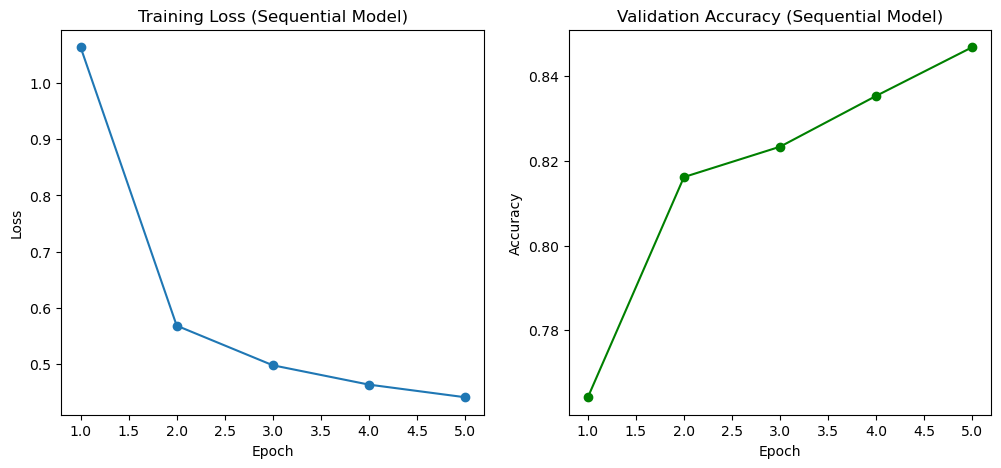

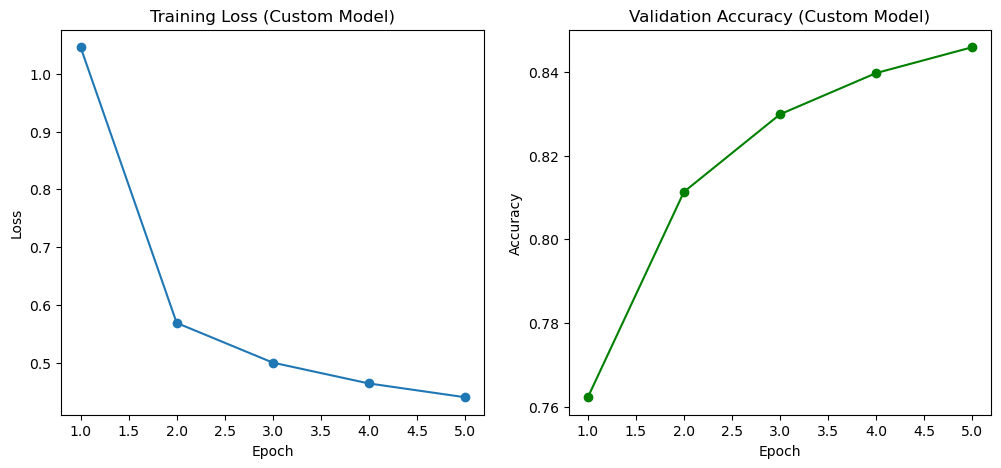

In [17]:
def plot_metrics(loss_history, accuracy_history, title_suffix=''):
    epochs = range(1, len(loss_history) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, marker='o')
    plt.title('Training Loss ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, marker='o', color='green')
    plt.title('Validation Accuracy ' + title_suffix)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

# Plot metrics for the sequential model
plot_metrics(loss_history_seq, val_accuracy_history_seq, title_suffix='(Sequential Model)')

# Plot metrics for the custom model
plot_metrics(loss_history_custom, val_accuracy_history_custom, title_suffix='(Custom Model)')

## Evaluating the Model: Confusion Matrix and Misclassified Images

We now evaluate our best model using a confusion matrix and display some misclassified images to analyze errors.

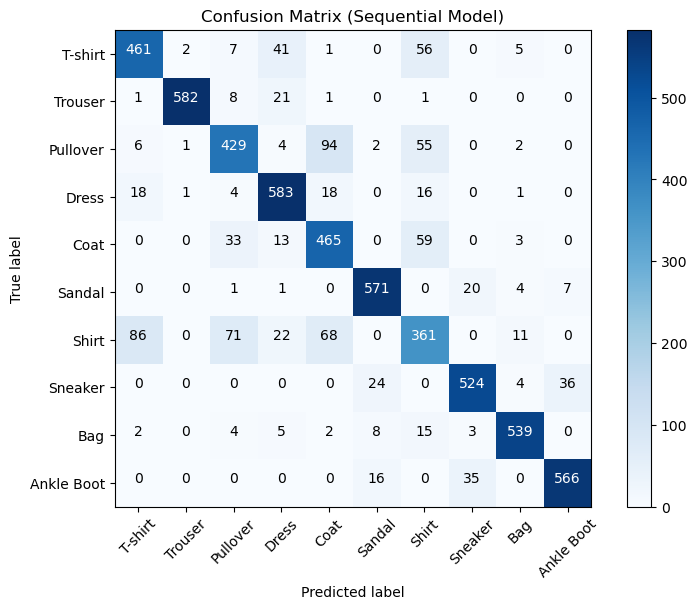

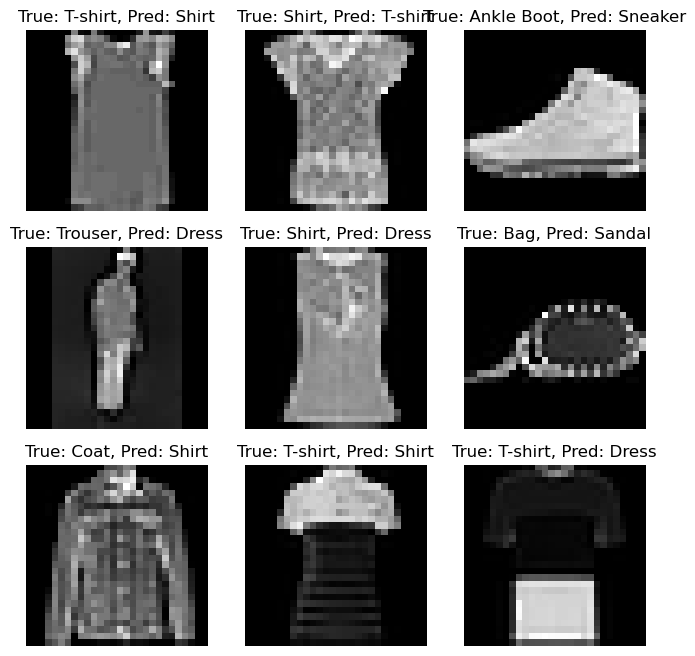

In [18]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate the model on the given data loader and return true labels and predictions.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            output = model(images)
            preds = output.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Evaluate the best sequential model on the validation data
true_labels, preds = evaluate_model(sequential_model, val_dataloader, device)
cm = confusion_matrix(true_labels, preds)
plot_confusion_matrix(cm, classes=FMNIST_labels_map, title='Confusion Matrix (Sequential Model)')

# Function to display misclassified images
def show_misclassified(model, data_loader, labels_map, device, num_samples=9):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            for i in range(len(labels)):
                if preds[i] != labels[i].to(device):
                    misclassified.append((images[i].cpu(), labels[i].item(), preds[i].item()))
                if len(misclassified) >= num_samples:
                    break
            if len(misclassified) >= num_samples:
                break
    
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for idx, (img, true_label, pred_label) in enumerate(misclassified[:num_samples]):
        figure.add_subplot(rows, cols, idx+1)
        plt.title(f'True: {labels_map[true_label]}, Pred: {labels_map[pred_label]}')
        plt.axis('off')
        plt.imshow(img.squeeze(), cmap='gray')
    plt.show()

# Display misclassified images for the sequential model
show_misclassified(sequential_model, val_dataloader, FMNIST_labels_map, device, num_samples=9)

## Summary

In this notebook, we implemented and compared two models, added a validation loop with checkpointing, and visualized performance metrics along with error analysis through a confusion matrix and misclassified images. This provides a comprehensive pipeline for training and evaluating neural networks with PyTorch.